In [1]:
#libraries
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from scipy.stats import randint
from imblearn.over_sampling import RandomOverSampler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, recall_score, precision_score

In [2]:
def top_features_extra_trees(x, y, k=37):
    """
    Perform feature importance calculation using an ensemble of decision trees,
    and plot the top k most important features.

    Parameters:
    - x: a pandas DataFrame containing the features
    - y: a pandas Series containing the target variable
    - k: the number of top features to plot (default: 10)

    Returns:
    None
    """
    extr = ExtraTreesClassifier()
    fit = extr.fit(x, y)
    feature_importance = extr.feature_importances_
    imp = pd.DataFrame(feature_importance, columns=['Gain_Score'])
    cols = pd.DataFrame(x.columns, columns=['Feature_Names'])
    gains = pd.concat([cols, imp], axis=1)
    largest_contribution = gains.nlargest(k, 'Gain_Score')
    samllest_contribution = gains.nsmallest(k, 'Gain_Score')
    largest_contribution.plot(x='Feature_Names', y='Gain_Score', kind='bar', color='cyan')
    plt.show()

    
def Performs_PCA(data):
    """
    Performs PCA 

    Args:
    data (pandas DataFrame): The input data.

    Returns:
    None
    """
    # Scale the data using MinMaxScaler
    mmx = MinMaxScaler()
    scaled_data = mmx.fit_transform(data)

    # Perform PCA with 3 componentsf
    pca = PCA(n_components=3)
    pca_data = pca.fit_transform(scaled_data)
    pca_df = pd.DataFrame(pca_data, columns=['pca1', 'pca2', 'pca3'])
    return pca_df

In [3]:
# Read the file 
df = pd.read_csv('Heart Disease.csv')

# encoding the dataset
label = LabelEncoder()
from pandas.core.dtypes.common import is_numeric_dtype

for column in df.columns:
    if is_numeric_dtype(df[column]):
        continue
    else:
        df[column] = label.fit_transform(df[column])
        
# separate features and target variable
x = df.drop('HeartDisease',axis=1)
y = df[['HeartDisease']]

# Balancing the dataset
from imblearn.over_sampling import RandomOverSampler
over = RandomOverSampler(random_state=42)
X, Y= over.fit_resample(x,y)
# Reshape the target variable
Y = Y["HeartDisease"] 

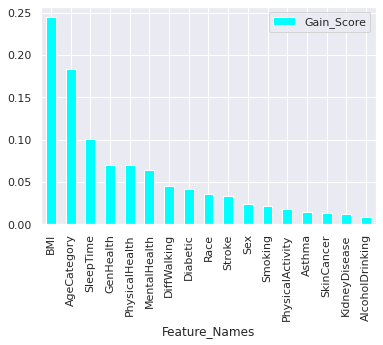

In [4]:
# Can you indicate which variables have a significant effect on the likelihood of heart disease?
top_features_extra_trees(X,Y)

### From left to right shows variables which have significant impact on Heart disease

In [5]:
# spliting into traing and testing sets
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, train_size=.70,random_state=42) 

# Train with Extra Trees Classifier algorithm 
extra_classifier =  ExtraTreesClassifier()# with default parameters
fit = extra_classifier.fit(xtrain, ytrain)

# print the testing and training accuracy
print(f"testing score from ExtraTreesClassifier: {fit.score(xtest, ytest)}")
print(f"testing score from ExtraTreesClassifier: {fit.score(xtrain, ytrain)}")

testing score from ExtraTreesClassifier: 0.9717019845657551
testing score from ExtraTreesClassifier: 0.9965802779745475


### So,  Extra Trees Classifier with default parameter perform well. Lets try some other algorithms.

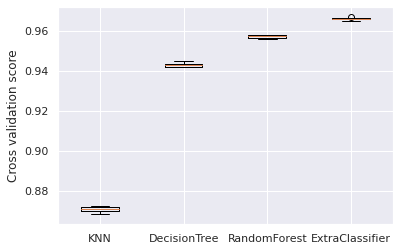

In [6]:
# Try with some others algorithms
models = { "KNN": KNeighborsClassifier(),"DecisionTree": DecisionTreeClassifier(), 
          "RandomForest": RandomForestClassifier(), "ExtraClassifier": ExtraTreesClassifier()}

results = []
for model in models.values():
    kf = KFold(n_splits=6, random_state=42, shuffle=True)
    cv_results = cross_val_score(model, xtrain, ytrain, cv=kf)
    results.append(cv_results)
    
plt.boxplot(results, labels=models.keys())
plt.ylabel("Cross validation score")
plt.show()

### Here, Cross validation score is higher for ExtraTreesClassifier

In [7]:
# print the testing and training accuracy
for name, model in models.items():
    model.fit(xtrain, ytrain)
    test_score = model.score(xtest, ytest)
    train_score = model.score(xtrain, ytrain)
    print("{} Test Set Accuracy: {}".format(name, test_score))
    print("{} Train Set Accuracy: {}".format(name, train_score))

KNN Test Set Accuracy: 0.8878908431839685
KNN Train Set Accuracy: 0.9188206844329369
DecisionTree Test Set Accuracy: 0.950431452118504
DecisionTree Train Set Accuracy: 0.9965802779745475
RandomForest Test Set Accuracy: 0.9640361576253605
RandomForest Train Set Accuracy: 0.996570507340189
ExtraClassifier Test Set Accuracy: 0.9716791865674194
ExtraClassifier Train Set Accuracy: 0.9965802779745475


### So, Its clear that ExtraTreesClassifier perform well. lets Evaluate the model

In [8]:
# Print Classification report
print(classification_report(ytest, extra_classifier.predict(xtest)))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     87576
           1       0.95      1.00      0.97     87878

    accuracy                           0.97    175454
   macro avg       0.97      0.97      0.97    175454
weighted avg       0.97      0.97      0.97    175454



In [9]:
# Print the confusion_matrix
con_matrix = confusion_matrix(ytest, extra_classifier.predict(xtest))
print(con_matrix)

[[82725  4851]
 [  114 87764]]


### So, there are 82734 cases when the model correctly predicted the absence of HeartDisease and 87769 cases when it correctly predicted HeartDisease. On the other hand, in 109 cases the model failed to predict HeartDisease and in 4842 cases it predicted HeartDisease which did not happen.

### For further improvement we can do hyperparmeter tuning, train the model with most important fetaures, perform PCA.

In [10]:
# performing pca
x_pca = Performs_PCA(X)

xtrain1, xtest1, ytrain1, ytest1 = train_test_split(x_pca, Y, test_size=.30, random_state=1)
fit2 = extra_classifier.fit(xtrain1, ytrain1)

print(f"testing score from ExtraTreesClassifier: {fit2.score(xtest1, ytest1)}") 
print(f"traing score from ExtraTreesClassifier: {fit2.score(xtrain1, ytrain1)}")


testing score from ExtraTreesClassifier: 0.9715196005790692
traing score from ExtraTreesClassifier: 0.996714624196976


### After perfroming pca I haven't see any improvement. Now, lets perform Hyperparameter tuning

In [11]:
# Hyperparameter tuning

# creating param_distributions for ExtraTreesClassifier
trees = np.random.randint(15,200,30)
grids = {
    'n_estimators': trees,
    'max_depth': [3, 4, 5, 6]
}
# fit into Randomized Search CV
rcv = RandomizedSearchCV(extra_classifier, grids, n_iter=2, cv=6)
fit_rcv = rcv.fit(xtrain, ytrain)

extra_classifier1 = fit_rcv.best_estimator_
extra_classifier1.fit(xtrain, ytrain) # training again

print(f"testing score from ExtraTreesClassifier: {extra_classifier1.score(xtest, ytest)}")
print(f"testing score from ExtraTreesClassifier: {extra_classifier1.score(xtrain, ytrain)}")

testing score from ExtraTreesClassifier: 0.75017383473731
testing score from ExtraTreesClassifier: 0.7518210019785535


### Its going worse. Its perform better with default parameter but I can check with all parameter but it will take so much time. So , I am going to skip it.